We will cover:
 - Removing and imputing missing values from the dataset;
 - Getting categorical data into shape for machine learning algorithms;
 - Selecting relevant features for the model construction.

# Dealing with missing data
Firstly we have to identify missing values (in this case in tabula data):

In [30]:
import pandas as pd
from io import StringIO
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,
'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [31]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

## Eliminating training examples or features with missing values
Rows with missing values can easily be dropped this way:

In [32]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


Similarly for columns:

In [33]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


- `df.dropna(how='all')` drop rows where all columns are NaN;
- `df.dropna(thresh=4)` drop rows that have fewer than 4 real values;
- `df.dropna(subset=['C'])` drow rows wheren NaN appear in specific columns (here 'C' for example).

## Imputing missing values
When a value is missing we can impute it with different techniques of interpolation. The most famous is the _mean imputation_, where we simply replace the missing value with the mean value of the entire feature column.
Scikit-learn offers different imputers:

In [34]:
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

- fit is used to learn the parameters from the training data;
- transform uses those parameters to transform the data.

Other options for the strategy parameter are `median` and `most_frequent` where we simply replace missing values with the most frequent.
A more handy approach is using the `df.fillna(<imputator>)` method, where everything is done directly from Pandas.

# Handling categorical data

In [35]:
df = pd.DataFrame([
    ['green','M',10.1,'class2'],
    ['red','L',13.5,'class1'],
    ['blue','XL',15.3,'class2'],
])
df.columns = ['color','size','price','classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


We need to map categorical information into ordinal information.

In [36]:
size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1,
}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [37]:
# To invert the mapping procedure:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## Encoding class labels

In [38]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))} # finding the uniques elements of that column and then enumerating it
class_mapping

{'class1': 0, 'class2': 1}

In [39]:
df['classlabel'] = df['classlabel'].map(class_mapping)
inv_class_mapping = {v: k for k,v in class_mapping.items()}
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [40]:
# A more convenient way of doing this with scikit learn is:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values) # To make it work, remove the class labeling done manually before

#Let's do it for the color
X = df[['color','size','price']].values
color_le = LabelEncoder()
X[:,0] = color_le.fit_transform(X[:,0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

Using this version of X is problematic though, because the model will understand that a color is "larger" or "smaller" than another, and this would be incorrect.

To solve this problem we will use the *one-hot encoding* method. Simply put, we create a dummy new feature for each unique value in the nominal feature column:

In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
X = df[['color','size','price']].values
c_transf = ColumnTransformer([
    ('onehot',OneHotEncoder(),[0]),
    ('nothing','passthrough',[1,2]), # Here we are saying to not do any transformation on the other two columns
])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [42]:
# A more convenient way of doing this in pandas is simply to call the get_dummies method
pd.get_dummies(df[['price','color','size']]).astype(float)

,price,size,color_blue,color_green,color_red
0,10.1,1.0,0.0,1.0,0.0
1,13.5,2.0,0.0,0.0,1.0
2,15.3,3.0,1.0,0.0,0.0


> Note that we are creating highly correlated features, and that could be a problem for certain machine learning algorithms.
To solve the problem we can remove in this case a feature column (since it can be derived by the other two)

In [43]:
pd.get_dummies(df[['price','color','size']], drop_first=True).astype(float)

,price,size,color_green,color_red
0,10.1,1.0,1.0,0.0
1,13.5,2.0,0.0,1.0
2,15.3,3.0,0.0,0.0


There are plenty more of encoding schemes for nominal data, especially encodings well suited for nominal features with high cardinality, for example:
- Binary encoding;
- Count or Frequency encoding.

In [44]:
# We could even encode ordinal features if we wanted to:
df['x > M'] = df['size'].apply(
    lambda x: 1 if x in [2, 3] else 0
)
df['x > L'] = df['size'].apply(
    lambda x: 1 if x == 3 else 0
)
del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,1,0,0
1,red,13.5,0,1,0
2,blue,15.3,1,1,1


# Partitioning a dataset into training and test sets

In [47]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [48]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)
# 30% in the test set and 70% in the training set
# stratify=y determines that the classes in the training set and the test set have the same proportions

The most common splits are 60:40, 70:30 or 80:20.

However for large datasets 90:10 or 99:1 are also common and appropriate.

## Feature scaling
It's a necessity for optimizing gradient descent and even to not bias machine learning algorithms to the features with bigger scales.

We can:
- normalize: we rescale the features between [0,1]
$$
x_{norm}^{(i)} = \frac{x^{(i)}-x_{min}}{x_{max}-x_{min}}
$$
- standardize: *more practical for many machine learning algorithms*.
    - Usually we randomly set the weights to values close to 0. With standardization we center feature columns at mean 0 and standard deviation of 1, which makes it much easier to learn weights.
    - Maintains useful information about outliers and makes the algorithm less sensitive to them (in contrast to min-max scaling (normalization)).
$$
x_{std}^{(i)}=\frac{x^{(i)}-\mu_x}{\sigma_x}
$$

In [49]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

# Standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

There is even a third option, the `RobustScaler` that's ideal when working with small datasets that contain many outliers, or if the machine learning algorithm used is prone to overfitting.

## Selecting meaningful features
Common solutions to solve overfitting are:
 - Collect more training data;
 - Introduce a penalty for complexity via regularization;
 - Choose a simpler model with fewer parameters;
 - Reduce the dimensionality of the data

### L2 regularization penality
$$
||w||_2 = \sum_{j=1}^m w_j^2
$$

### L1 regularization penality
$$
||w||_1 = \sum_{j=1}^m |w_j|
$$
It can be understood as a feture selection technique since it yields sparse feature vectors, that can be really useful with high-dimensional datasets with many features that are irrelevant.
See page 124-125 to have a better visual understanding of why.

In [58]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(
    penalty='l1', # regularization penalty applied
    C=1, # regularization coefficient
    solver='liblinear', # an optimizer that can use the l1
)
lr.fit(X_train_std,y_train)
print(f'Train accuracy: {lr.score(X_train_std,y_train)}')
print(f'Test accuracy: {lr.score(X_test_std,y_test)}')

Train accuracy: 1.0
Test accuracy: 1.0


In [60]:
print(f"Biases for the three models (OvR): \n{lr.intercept_}")
print(f"Weights for the three models (OvR): \n{lr.coef_}")

Biases for the three models (OvR): 
[-1.26387598 -1.21590361 -2.37048442]
Weights for the three models (OvR): 
[[ 1.24543311  0.18060471  0.74635603 -1.1638175   0.          0.
   1.15894914  0.          0.          0.          0.          0.55882018
   2.50904729]
 [-1.53724706 -0.38718381 -0.99519554  0.3649849  -0.05953626  0.
   0.66789641  0.          0.         -1.93415692  1.23389307  0.
  -2.23170122]
 [ 0.13551975  0.16951167  0.35787833  0.          0.          0.
  -2.43327675  0.          0.          1.5621109  -0.81752423 -0.49766637
   0.        ]]


It's noticeable how it's selecting features, since some of them have a weight valued 0.

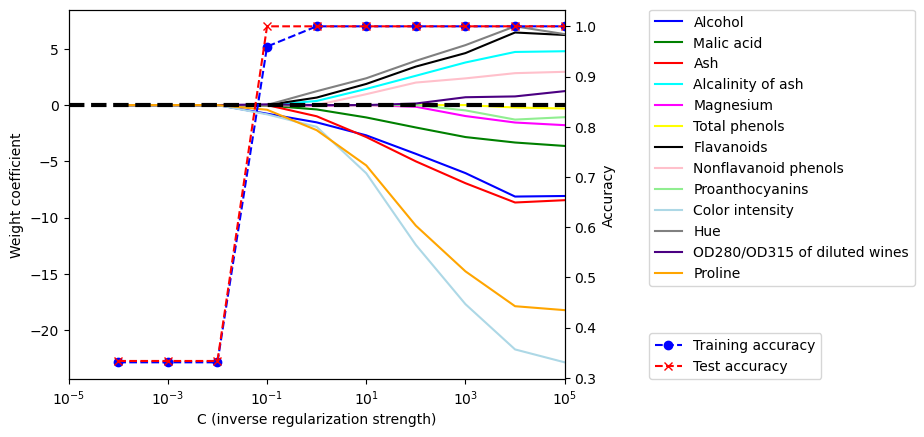

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

fig, ax1 = plt.subplots()

colors = [
    "blue",
    "green",
    "red",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "pink",
    "lightgreen",
    "lightblue",
    "gray",
    "indigo",
    "orange",
]
weights, params, train_acc, test_acc = [], [], [], []

for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty="l1", C=10.0**c, solver="liblinear", random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.0**c)

    # Calcolo dell'accuracy
    train_acc.append(accuracy_score(y_train, lr.predict(X_train_std)))
    test_acc.append(accuracy_score(y_test, lr.predict(X_test_std)))

weights = np.array(weights)

# Tracciare i coefficienti dei pesi
for column, color in zip(range(weights.shape[1]), colors):
    ax1.plot(params, weights[:, column], label=df_wine.columns[column + 1], color=color)

ax1.axhline(0, color="black", linestyle="--", linewidth=3)
ax1.set_xscale("log")
ax1.set_xlim([10 ** (-5), 10**5])
ax1.set_xlabel("C (inverse regularization strength)")
ax1.set_ylabel("Weight coefficient")
ax1.legend(loc="upper left", bbox_to_anchor=(1.17, 1), borderaxespad=0.0)

# Crea un secondo asse y per l'accuracy
ax2 = ax1.twinx()
ax2.plot(
    params,
    train_acc,
    color="blue",
    linestyle="--",
    marker="o",
    label="Training accuracy",
)
ax2.plot(
    params, test_acc, color="red", linestyle="--", marker="x", label="Test accuracy"
)
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower left", bbox_to_anchor=(1.17, 0), borderaxespad=0.0)

plt.show()

## Dimensionality reduction via feature selection
- feature selection: we select a subset of the original features;
- feature extraction: we derive information from the feature set to construct a new feature space

### Feature selection via Sequential Backward Selection
This technique sequentially removes features from the full feature subset until the new feature subspace contains the desired number of features.

To determine which feature is to be removed at each stage, we need to define the criterion function, _J_, that we want to minimize.

1. Initialize the algorithm with _k = d_, where _d_ is the dimensionality of the full feature space, $X_d$.
2. Determine the feature, $x^-$, that maximizes the criterion: $x^- = argmaxJ(X_k-x)$,where $x\in X_k$.
3. Remove the feature, $x^-$, from the feature set: $X_{k-1}=X_k-x^-;k=k-1$.
4. Terminate if _k_ equals the number of desired features; otherwise, go to step 2.

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from SBS import SBS
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn,k_features=1)
sbs.fit(X_train_std,y_train)

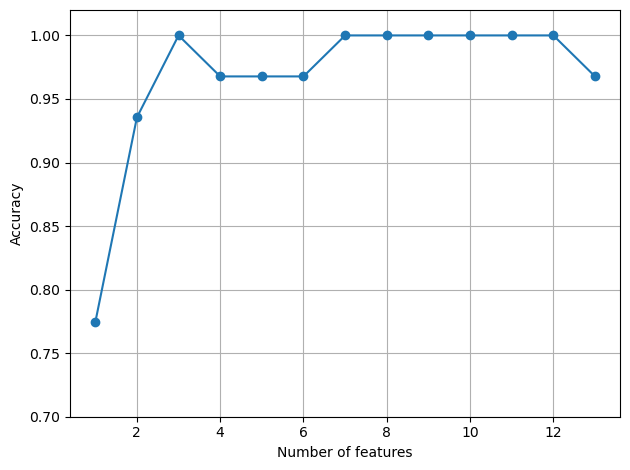

In [69]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylim([0.7,1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [72]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [73]:
knn.fit(X_train_std,y_train)
print(f'Training accuracy: {knn.score(X_train_std,y_train)}')
print(f'Test accuracy: {knn.score(X_test_std,y_test)}')

Training accuracy: 0.967741935483871
Test accuracy: 0.9814814814814815


In [75]:
knn.fit(X_train_std[:,k3],y_train)
print(f'Training accuracy: {knn.score(X_train_std[:,k3],y_train)}')
print(f'Test accuracy: {knn.score(X_test_std[:,k3],y_test)}')

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


Notice that we did not increase the performance of the KNN model by reducing the number of features, we shrank the size of the dataset, **which can be useful in real-world applications that may involve expensive data collection steps**.

Also we obtained an easier model, which is easier to intepret.

## Assessing feature importance with random forests

The only gotcha is that if two features are highly correlated, one may be ranked very highly while the other one could go unnoticed.

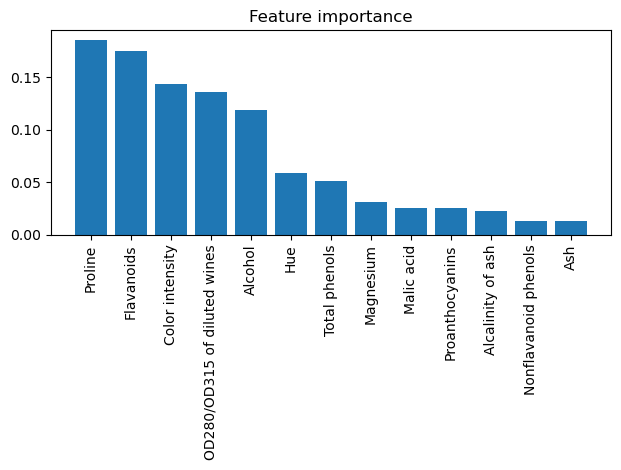

In [78]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500,random_state=1)
forest.fit(X_train,y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

In [82]:
# sklearn object to use a model to select features based on model evalutation
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train) # it extracts only the most relevant features
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
